# Categorizing retinal ganglion celltypes with density-based clustering
Here, we examine the response of RGCs to a repeated trial consisting of
1s darkness, 0.5s full-field white flash, and 2s darkness. We preprocess the
data such that we cluster on the trial-averaged firing rate of each cell.
As RGCs tend to decrease in firing rate over time, we use a cosine distance metric.
With minimal hyperparameter tuning, OPTICS provides consistent clustering results.
As currently configured, this notebook examines over 7000 RGCs recorded from
19 wild-type mouse retinas using a MultiChannel Systems 60 channel microelectrode array. 

author: Tyler Benster

date: 2020-06-28

## imports

will need to install all dependencies, including glia: https://github.com/tbenst/glia

In [1]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import glia
from glia.config import channel_map
import pandas as pd
from importlib import reload
import csv
import seaborn as sns
from scipy import signal
import numpy as np
import scipy
import os
import sys
import traceback
import glia
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import datasets, svm, metrics, neighbors
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import os
from functools import reduce, partial
from scipy import stats
from pathlib import Path
from tqdm import tqdm

reload(glia)
from sklearn.decomposition import PCA

## Drivers (key parameters)

In [2]:
plt.rcParams["font.size"] = 18
data_dir = "/home/tyler/Dropbox/Science/manuscripts/2019_acuity_paper/acuity_paper/code/"

# more accurately named retina_type_map
cell_type_map = ["wt","dnqx","washout","benaq","melrd"]

exp_type = {'R1_E1_AMES_130min_checkerboard_contrast': 0,
    'R1_E1_AMES_60min_grating_speeds': 0,
    'R1_E2_AMES_140min_grating_speeds': 0,
    'R1_E2_AMES_160min_grating_durations': 0,
    'R1_E1_AMES_70min_grating_durations': 0,
    'R1_E4_AMES_280min_checkerboard_durations': 0,
    'R1_E2_AMES_140min_checkerboard_durations': 0,
    'R2_E2_AMES_280min_grating_contrast': 0,
    'R2_E1_AMES_270min_checkerboard_contrast': 0,
    'R2_E7_DNQX_AP5_415min_checkerboard_contrast': 1,
    'R2_E10_WASHOUT_515min_checkerboard_contrast': 2,
    'R2_E3_AMES_310min_grating_speeds': 0,
    'R2_E8_DNQX_AP5_435min_grating_speeds': 1,
    'R2_E12_WASHOUT_550min_grating_speeds': 2,
    'R1_E1_AMES_60min_green_checkerboard_contrast': 0,
    'R1_E2_AMES_150min_blue_checkerboard_contrast': 0,
    'R1_E4_AMES_320min_blue_grating_speeds': 0,
    'R1_E3_AMES_230min_green_grating_speeds': 0,
    'R1_E4_AMES_350min_green_grating_durations': 0,
    'R1_E3_AMES_290min_blue_grating_durations': 0,
    'R1_E4_AMES_310min_green_checkerboard_durations': 0,
    'R1_E3_AMES_230min_blue_checkerboard_durations': 0,
    'R1_E3_AMES_240min_letters': 0,
    'R2_E1_BENAQ_150min_grating_speeds': 3,
    'R3_E3_BENAQ_350min_checkerboard_contrast': 3,
    'R1_E5_BENAQ_480min_grating_speeds': 3,
    'R1_E2_BENAQ_250min_grating_durations': 3,
    'R1_E3_BENAQ_300min_checkerboard_contrast': 3,
    'R1_E1_BENAQ_190min_grating_contrast': 3,
    'R1_E1_AMES_60min_checkerboard_contrast': 4,
    'R1_E2_BENAQ_300min_grating_contrast': 3,
    'R1_E3_BENAQ_360min_grating_contrast': 3,
    'R1_E1_BENAQ_120min_grating_contrast': 3,
    'R1_E2_BENAQ_210min_grating_contrast': 3,
    'R1_E1_AMES_120min_grating_contrast': 5} # 3brain


# look at wild type (wt)
retina_type_to_look_at = 0 # 0-5

#### only cluster single experiment
## (choose one, or None for running on all retina of specified type)
name = None
# name = "R1_E4_AMES_320min_blue_grating_speeds"
# name = "R2_E2_AMES_280min_grating_contrast" # particularly good experiment
# name = "R1_E3_AMES_240min_letters"

timebin_duration = "1ms" # "1ms" or "100ms"
n_components = 2 # for PCA dimensionality reduction before clustering

# Data munging

In [3]:
rgcs_100ms = pd.read_csv(data_dir+"integrity_units.csv")
# different sizes???
# rgcs_1ms = pd.read_csv("integrity_units_1ms.csv")

maxms = 3500
# we will throw out some data later so all are same length
rgcs_1ms = pd.read_csv(data_dir+"integrity_units_1ms.csv",
                       names=['retina', 'i', 'j', 'unit_num', 'ntrials'] + list(map(str, np.arange(maxms))), skiprows=1)

if timebin_duration=="1ms":
    rgcs = rgcs_1ms
elif timebin_duration=="100ms":
    rgcs = rgcs_100ms
else:
    raise(NotImplementedError("bad timebin_duration"))

rgc_type = np.array([exp_type[x] for x in np.array(rgcs.index)])

### normalization & firing rate calculation

In [4]:
spike_counts = np.sum(np.array(rgcs.iloc[:,5:]),1)

# normalize each cell's response to ntrials
# (different recordings may have differing trial count)
norm_rgc_array = np.array(rgcs.iloc[:,5:]) / np.array(rgcs.iloc[:,4])[:,None]

# Alternatively, normalize to percent of spikes per time bin
# norm_rgc_array = np.array(rgcs.iloc[:,5:]) / spike_counts[:,None]


# estimate firing rate using gaussian smoothing
sigma = 6
bandwidth = 0.05 # sec
bin_width = 0.001
transformed_sigma = bandwidth/bin_width
window = signal.gaussian(2*sigma*transformed_sigma, std=transformed_sigma)

# instantaneous firing rate (acausal)
ifr = np.array([signal.convolve(unit, window,mode="same")*1/bandwidth for unit in norm_rgc_array])

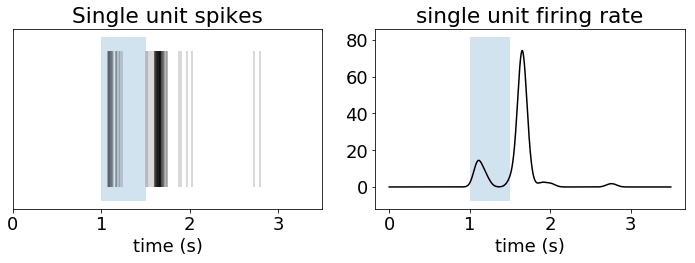

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.vlines(np.where(rgcs.iloc[0,5:])[0]/1000, 0, 1,colors='k',alpha=0.2)
plt.fill([1,1.5,1.5,1], [-0.1,-0.1,1.1,1.1], alpha=0.2)
plt.xlim(0,3.5)
plt.title("Single unit spikes")
plt.xlabel("time (s)")
plt.yticks([])

plt.subplot(122)
plt.plot(np.arange(maxms)/1000, ifr[0],color='k')
shade_max = ifr[0].max()
shade_min = 0 - 0.1 * shade_max
shade_max += 0.1 * shade_max
plt.fill([1,1.5,1.5,1], [shade_min,shade_min,shade_max,shade_max], alpha=0.2)
plt.title("single unit firing rate")
plt.xlabel("time (s)")

plt.tight_layout()

### select rgcs to analyze

In [6]:
#### only cluster cells of particular retina type
rows = np.logical_and(rgc_type==retina_type_to_look_at, spike_counts>0)

if name:
    rows = np.logical_and(rgcs.index==name, spike_counts>0)

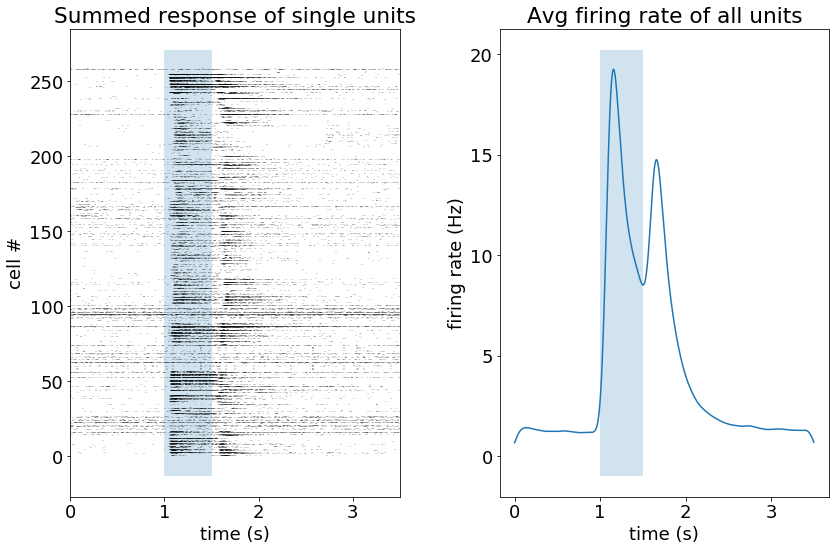

In [7]:
# each trial has three stimuli: 1s dark, 0.5s light, 2s dark
# Note: right now the firing rate kernel is acausal,
# hence response "starting" 0.05 seconds before onset of light

plt.figure(figsize=(12,8))
plt.subplot(121)

if rows.sum() > 400:
    # visualize every 15th cell
    # matplotlib starts dropping lines if plotting too many without sufficient height
    every_k = 15
else:
    every_k = 1
for i,r in enumerate(np.where(rows)[0][::every_k]):
    plt.vlines(np.where(rgcs.iloc[r,5:])[0]/1000, i+0.3, i+1,colors='k',alpha=0.2)
plt.xlim(0,3.5)
shade_max = i
shade_min = 0 - 0.05 * shade_max
shade_max += 0.05 * shade_max
plt.fill([1,1.5,1.5,1], [shade_min,shade_min,shade_max,shade_max], alpha=0.2)
plt.xlabel("time (s)")
plt.ylabel("cell #")
plt.title(f"Summed response of single units")

plt.subplot(122)
summed_response = np.array(ifr[rows].sum(axis=0)) / len(rows)
plt.plot(np.arange(maxms)/1000, summed_response)
shade_max = summed_response.max()
shade_min = 0 - 0.05 * shade_max
shade_max += 0.05 * shade_max
plt.fill([1,1.5,1.5,1], [shade_min,shade_min,shade_max,shade_max], alpha=0.2)
plt.xlabel("time (s)")
plt.ylabel("firing rate (Hz)")
plt.title("Avg firing rate of all units")

plt.tight_layout()

### cluster

In [8]:
# choose whether to use normalization or firing rate
# data = norm_rgc_array[rows]
data = ifr[rows]

# %%
pca = sklearn.decomposition.PCA(n_components=n_components)
lowdim_data = pca.fit_transform(data)
# plt.scatter(lowdim_data[:,0],lowdim_data[:,1],c=cells.cluster)

# handcrafted bins
# lowdim_data = np.concatenate([
#         np.sum(data[:,0:5],1,keepdims=True),
#         np.sum(data[:,5:7],1,keepdims=True),
#         np.sum(data[:,7:11],1,keepdims=True),
#         np.sum(data[:,11:13],1,keepdims=True),
#         np.sum(data[:,13:15],1,keepdims=True),
#     ], 1)

# rgcs.where(rgcs.apply(lambda x: bool(exp_type[x.index])))
# cluster the data

# optics = sklearn.cluster.OPTICS(min_samples=20, xi=.05, metric='cosine')
# optics = sklearn.cluster.OPTICS(min_samples=30, xi=.02,metric="cosine") # 4 clusters
# optics = sklearn.cluster.OPTICS(min_samples=50, xi=.01,metric="cosine")
# metric = "l1"
# metric = "rogerstanimoto"

#### good settings ####
## for all retinas
# metric = "cosine"
# xi = 0.05
# min_samples = 50

## for single retina
# metric = "cosine"
# xi = 0.05
# min_samples = 8
#######################

metric = "cosine"
xi = 0.05
min_samples = 50

# data_cov = np.cov(data.transpose())
# optics = sklearn.cluster.OPTICS(min_samples=min_samples, xi=xi ,metric=metric, metric_params={'V': data_cov+np.random.randn(*data_cov.shape)*1e-8})
optics = sklearn.cluster.OPTICS(min_samples=min_samples, xi=xi ,metric=metric)
# optics = sklearn.cluster.OPTICS(xi=xi ,metric=metric)
# optics = sklearn.cluster.DBSCAN(metric=metric,eps=0.01,min_samples=7)
optics.fit(lowdim_data)
# optics.fit(data)

labels = optics.labels_
nclust = max(labels)+1
palette = sns.color_palette("colorblind", nclust)

def plot_cluster_traces(data, labels, csv_name=None):
    means = []
    cells = []
    ncells = []
    nclust = max(labels)+1
    print(nclust)
    # for c in range(-1,nclust):
    # ignore unclustered
    for c in range(-1,nclust):
        ncell = np.sum(labels==c)
        ncells.append(ncell)
        means.append(np.mean(data[labels==c],0))
        # cells.append(np.concatenate([np.full([ncells,1],f"clust {c}: {ncells}"),data[labels==c]],1))
        # print(len(np.array(rgcs.iloc[rows,0][labels==c])),np.sum(labels==c))
        cells.append(np.concatenate([
            # add index for concatenate
            rgcs.index[rows][labels==c][:,None],
            np.array(rgcs.iloc[rows,0][labels==c][:,None]), # cell name
            np.full([ncell,1],c),
            data[labels==c]],1)
            )

    cells = pd.DataFrame(data=np.concatenate(cells),columns = \
        ["retina", "unit_id",
        # [ \
         "cluster"]+list(np.arange(data.shape[1])))
    # collapse columns (time) to long format, one row per timepoint
    melt_cells = cells.iloc[:,2:].melt('cluster', var_name='time',  value_name='spikes')
    # melt_cells = cells.melt('cluster', var_name='time',  value_name='spikes')

    # Why? pandas craziness
    melt_cells.cluster = melt_cells.cluster.astype(float)
    melt_cells.spikes = melt_cells.spikes.astype(float)
    melt_cells.time = melt_cells.time.astype(float)/1000 # convert to seconds

    if csv_name:
        cells.iloc[:,:3].to_csv(f"{csv_name}.csv")

    # %#%
    # plot firing rate
    # drop unclustered
    melt_cells = melt_cells[melt_cells.cluster!=-1]
    melt_cells.cluster.unique()
    # must be categorical for seaborn
    palette = sns.color_palette("colorblind", nclust)
    len(palette)

    # melt_cells_new = melt_cells
    ymin = 0
    # letters
    ymax = 250
    # gratings
    ymax = 120
    nrow = ((nclust-1) // 4) + 1
    g = sns.FacetGrid(melt_cells, col="cluster", hue="cluster", col_wrap=4, height=nrow, ylim=(ymin, ymax), palette=palette, size=3)
    g.map(sns.lineplot, "time", "spikes", legend=False, ci="sd");

    offset = 1
    end_time = 1.5
    # offset = 4
    # end_time = 9 + 1
    for c,ax in zip(np.arange(0,nclust),g.axes):
        ax.set_title(f"clust {c}: {np.sum(labels==c)} cells")
        ax.fill([offset,end_time,end_time,offset],
                        [ymin,ymin,ymax,ymax],
                        facecolor="gray",
                        edgecolor="none", alpha=0.1)

    [ax.set_ylabel("firing rate (Hz)") for ax in g.fig.axes]
    [ax.set_xlabel("time (s)") for ax in g.fig.axes]
    return cells, g.fig

18


/home/tyler/lib/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


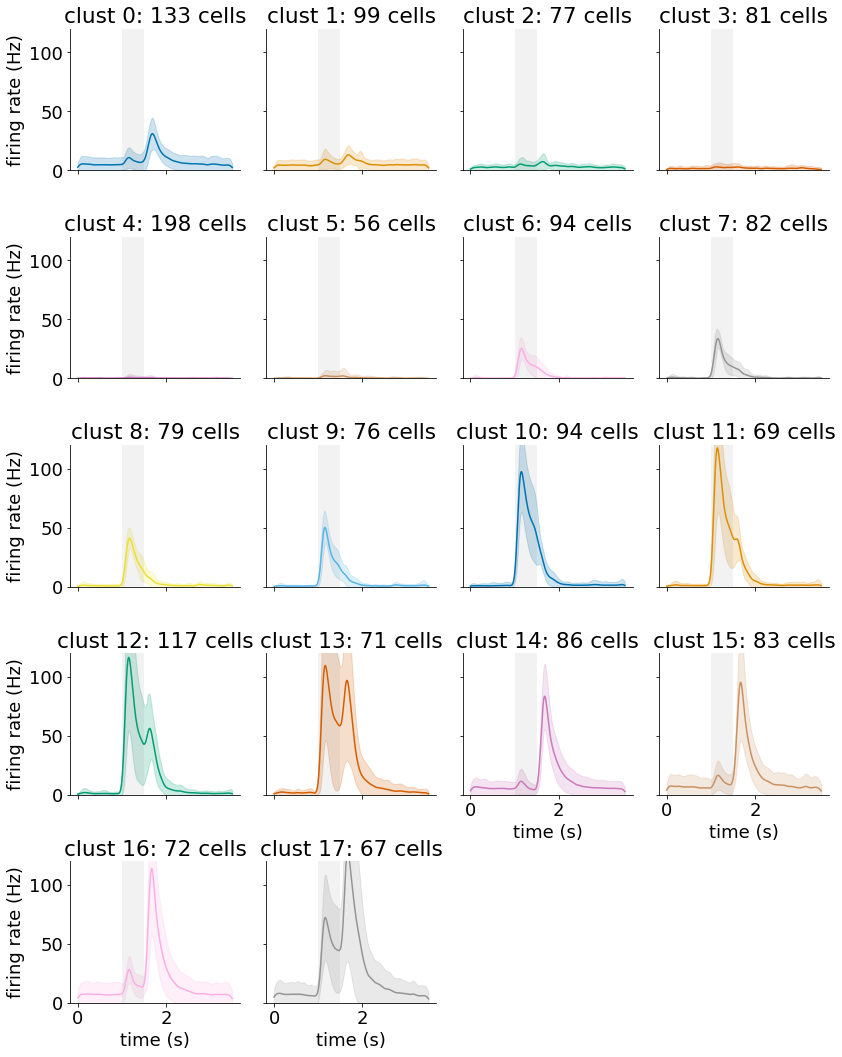

In [9]:
# WARNING: this code takes a long time to run if there 
# are a bunch of clusters. Consider interrupting if the number
# printed is above 50
# best to run on computer with lots of CPUs

# can set csv_name= to save CSV file of clustering results
# csv_name = f"{name}_cluster_optics_{cell_type_map[i]}"
csv_name = None
optics_cells, optics_cluster_traces = plot_cluster_traces(data,labels,csv_name)

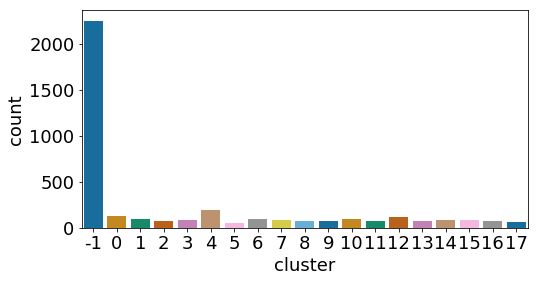

In [10]:
# -1 means not clustered
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot("cluster", palette=palette, data=optics_cells, ax=ax)

### epsilon threshold
code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py

In [11]:
# CHANGE ME: you'll need to set the epsilon threshold
# depending on data based on reachability plot below

## letter
# eps1 = 6e-3
# eps2 = 1.8e-2

## grating contrast
# eps1 = 4e-3
# eps2 = 1.6e-2

## all wt retinas
eps1 = 3e-3
eps2 = 1.7e-3

[5, 4]


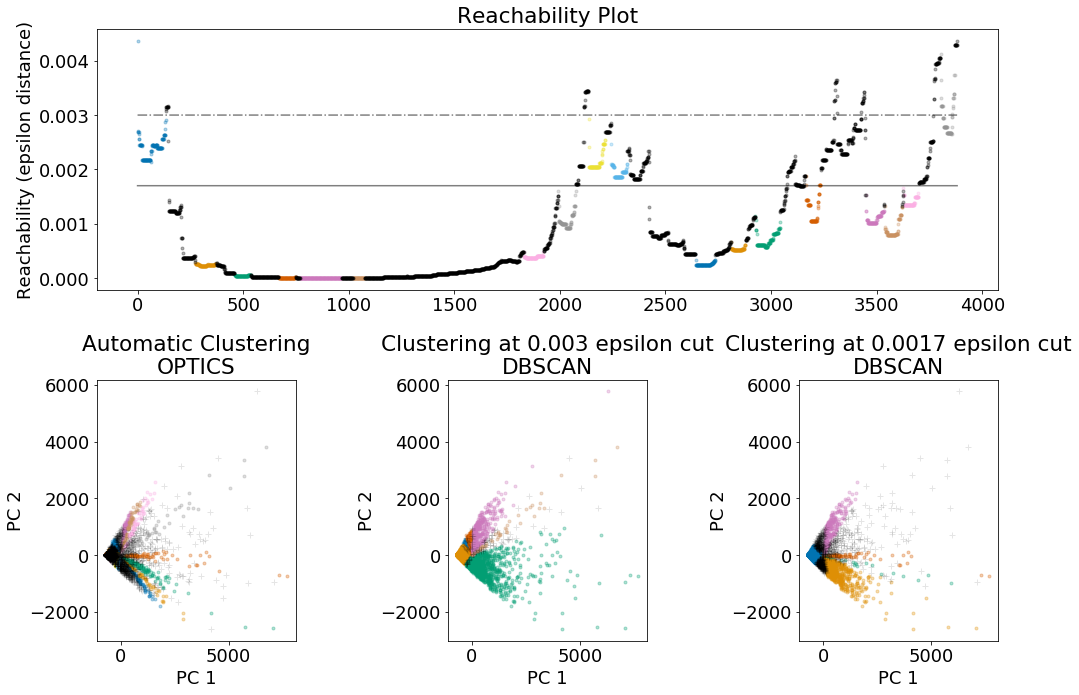

In [12]:
labels_1 = sklearn.cluster.cluster_optics_dbscan(reachability=optics.reachability_,
                                   core_distances=optics.core_distances_,
                                   ordering=optics.ordering_, eps=eps1)
labels_2 = sklearn.cluster.cluster_optics_dbscan(reachability=optics.reachability_,
                                   core_distances=optics.core_distances_,
                                   ordering=optics.ordering_, eps=eps2)

label_eps = [sklearn.cluster.cluster_optics_dbscan(reachability=optics.reachability_,
                                   core_distances=optics.core_distances_,
                                   ordering=optics.ordering_, eps=eps)
        for eps in [eps1, eps2]]
print(list(map(max,label_eps)))

fig = plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
X = lowdim_data
space = np.arange(len(X))
nclust
reachability = optics.reachability_[optics.ordering_]
reach_labels = optics.labels_[optics.ordering_]

for klass, color in zip(range(0, nclust), palette):
    Xk = space[reach_labels == klass]
    Rk = reachability[reach_labels == klass]
    ax1.plot(Xk, Rk, color=color, marker='.', linestyle='None', alpha=0.3)
ax1.plot(space[reach_labels == -1], reachability[reach_labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, eps2, dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, eps1, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
for klass, color in zip(range(0, nclust), palette):
    Xk = X[optics.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color=color, linestyle='None', marker='.', alpha=0.3)
ax2.plot(X[optics.labels_ == -1, 0], X[optics.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")

# DBSCAN at 0.5
for klass, color in zip(range(0, max(labels_1)+1), palette):
    Xk = X[labels_1 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color=color, linestyle='None', marker='.', alpha=0.3)
ax3.plot(X[labels_1 == -1, 0], X[labels_1 == -1, 1], 'k+', alpha=0.1)
ax3.set_title(f'Clustering at {eps1} epsilon cut\nDBSCAN')
ax3.set_xlabel("PC 1")
ax3.set_ylabel("PC 2")

# DBSCAN at 2.
for klass, color in zip(range(0, max(labels_2)+1), palette):
    Xk = X[labels_2 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color=color, linestyle='None', marker='.', alpha=0.3)
ax4.plot(X[labels_2 == -1, 0], X[labels_2 == -1, 1], 'k+', alpha=0.1)
ax4.set_title(f'Clustering at {eps2} epsilon cut\nDBSCAN')
ax4.set_xlabel("PC 1")
ax4.set_ylabel("PC 2")

fig.tight_layout()

6


/home/tyler/lib/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


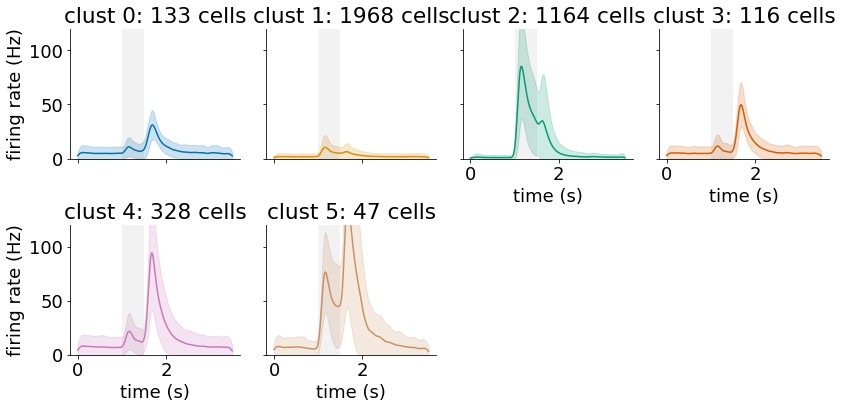

In [13]:
csv_name1 = None
eps1_cells, eps1_traces = plot_cluster_traces(data,labels_1,csv_name1)

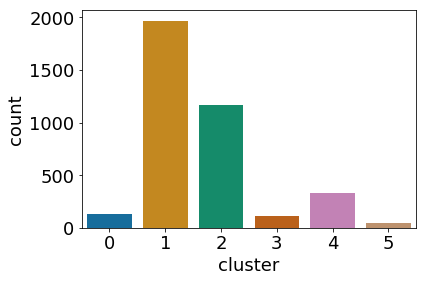

In [14]:
fig, ax = plt.subplots()
sns.countplot("cluster", palette=palette, data=eps1_cells[eps1_cells.cluster!=-1], ax=ax)

5


/home/tyler/lib/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


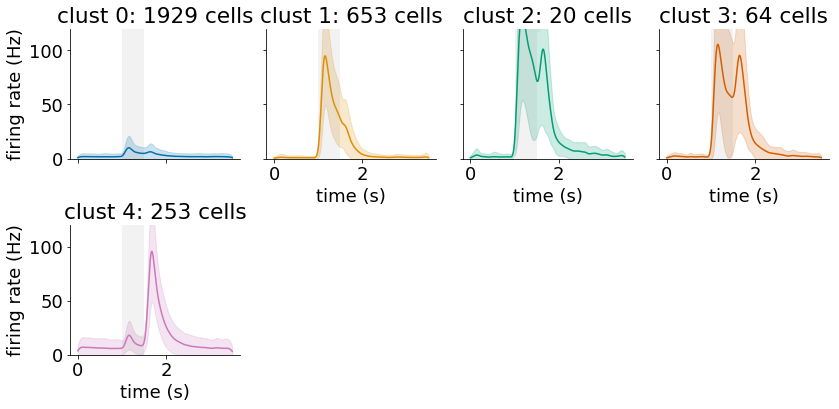

In [15]:
csv_name2 = None
eps2_cells, eps2_traces = plot_cluster_traces(data,labels_2,csv_name2)

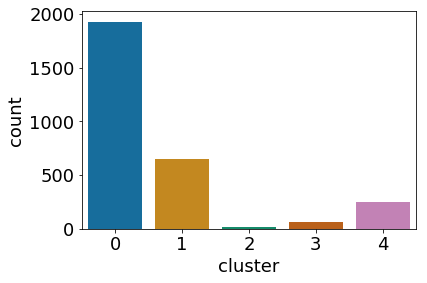

In [16]:
fig, ax = plt.subplots()
sns.countplot("cluster", palette=palette, data=eps2_cells[eps2_cells.cluster!=-1], ax=ax)

/home/tyler/lib/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


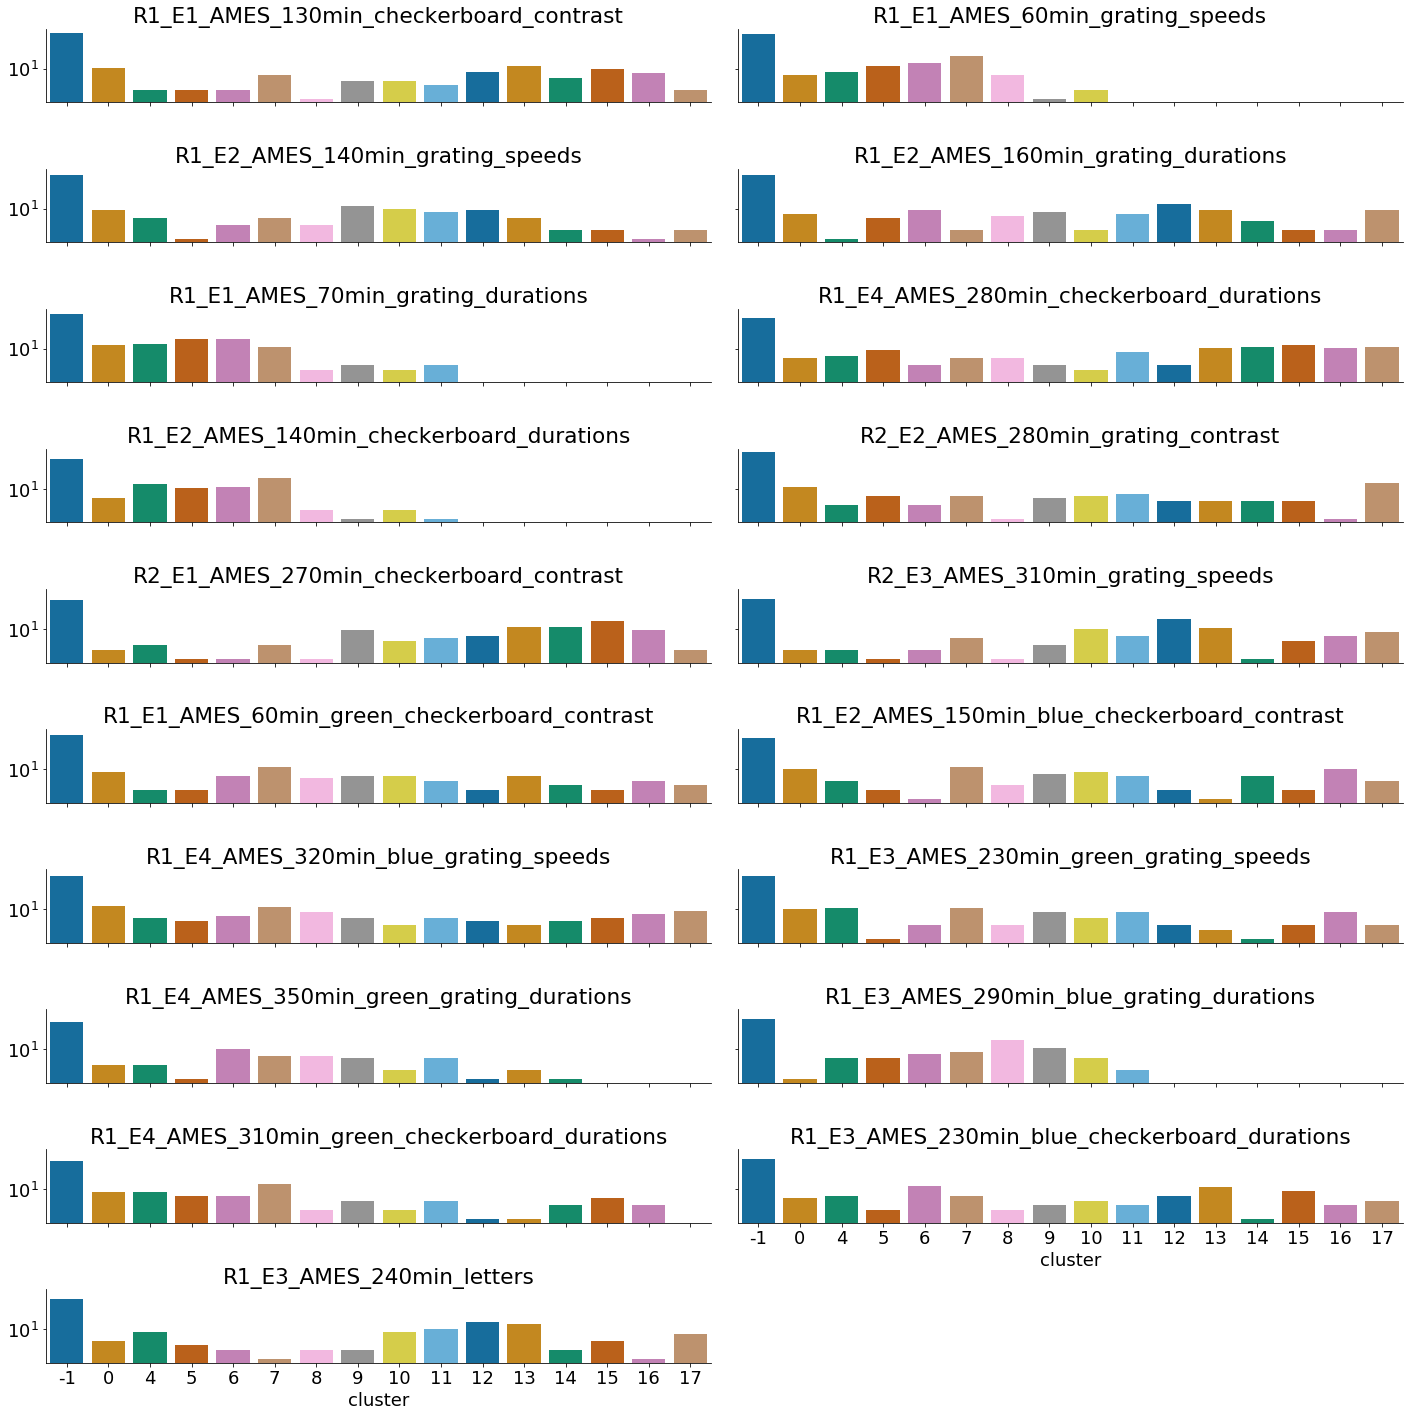

In [17]:
# %%
# plot cell count by retina
# we want to ensure that cell types appear accross most retinas
# as we want to find canonical cell types
# but some rare cell types may not appear in every recording

g = sns.FacetGrid(optics_cells, col="retina", col_wrap=2, height=2,aspect=5)
g.map(sns.countplot,"cluster", palette=palette);
for ax in g.axes:
    ax.set_yscale('log')
    ax.set_title(ax.get_title()[9:])